# 18. 문자를 읽을 수 있는 딥러닝



# 18-7. keras-ocr 써보기

위에서 구글 API를 쓰듯이 OCR을 데모로 써볼 수 있지만 직접 OCR 모델을 만들어 돌려보고 싶을 때는 어떻게 해야 할까요? 저희는 텐서플로우 기반의 모델을 주로 다뤄왔으니 텐서플로우를 기반으로 모델을 구현해서 OCR을 직접 돌려보도록 하겠습니다.

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj47/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel-dj47/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize() 에 이미지를 몇 개 넣어줍니다.
이미지소스의 url을 사용할건데요. 이미지는 https://unsplash.com/s/photos/text 에서 가져왔습니다.



In [6]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
    'https://source.unsplash.com/W_6b8pWBUKY',
    'https://source.unsplash.com/TSo9iu4ZBMk',
    'https://source.unsplash.com/2nbIfDeT4t4',
    'https://source.unsplash.com/LcvKoG_MS3k',
    'https://source.unsplash.com/bcZxqAD60qw',
    'https://source.unsplash.com/jj3r66419Lc', 
    'https://source.unsplash.com/r5NG8QBkOhQ',
    'https://source.unsplash.com/7x13D6qqOho',
    'https://source.unsplash.com/jFu29QqO2yg',
    'https://source.unsplash.com/3ujfoSnBcI4',
    'https://source.unsplash.com/zvL4T3Pum0g',
    'https://source.unsplash.com/12Lge8Yb-z8',
    'https://source.unsplash.com/vIacHQ5ZqxY',
    'https://source.unsplash.com/clMXC8xr4yk',
    'https://source.unsplash.com/FGGiIqvv6fA',
    'https://source.unsplash.com/o2hMsIyjbGE',
    'https://source.unsplash.com/T9yIW2oIEbE',
    'https://source.unsplash.com/kVxhRBQUY2Q',
    'https://source.unsplash.com/fgvf4QgTn5Y',
    'https://source.unsplash.com/z7oytXGI6VI'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

이제 인식된 결과를 pyplot으로 시각화를 해봅니다.

사용이 매우 간단합니다! 내부적으로 recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 합니다

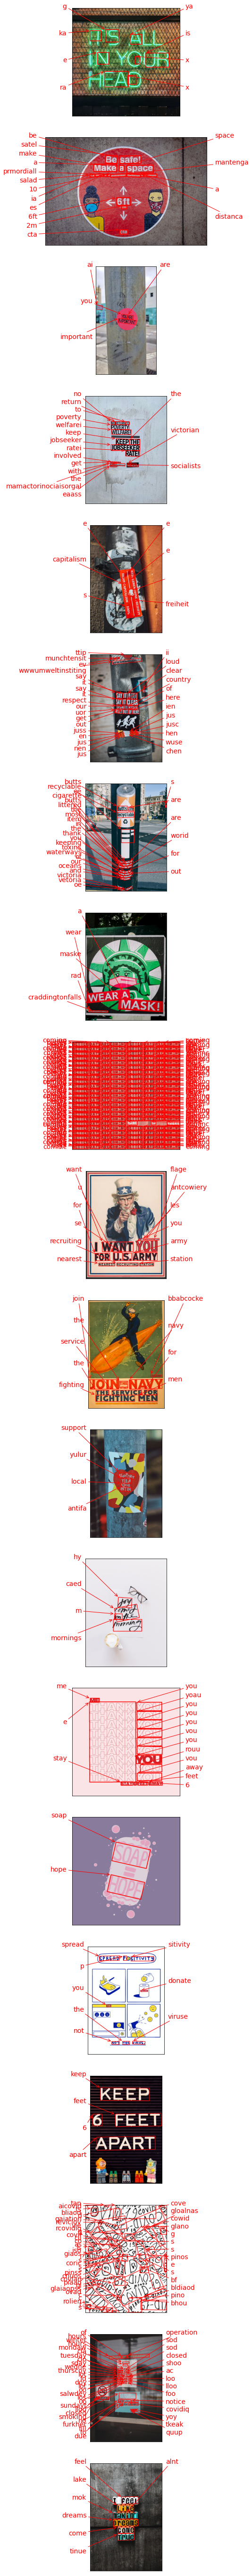

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

1. 네온사인 조형물 제대로 인식 못함
2. 느낌표를 l로 인식
3. 
4. 
5. 글자가 누워져있어서 그런지 인식하는 것도 있고 못하는 것도 있음
6. 
7. 
8. 
9. 
10. 
11. 
12. 
13. 사람이 쓴 필기체 같은데 내가봐도 좀 명확한 거는 잘 나오고 애매한건 잘 안나옴
14. thank를 하나씩이 아닌 전체로 인식했는데 그 마저도 e라고 나옴, 반면 you는 꽤 잘 각각의 you로 잘 인식함
15. 
16. 
17. 
18. 전부 covid-19로 써 있는 것인데 글자가 반전되어있거나, 대각선이거나 제대로 인식 못함 
19. 
20. 

(주의사항)
keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델입니다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의해 주세요.

# 18-8. 테서랙트 써보기


이번에는 테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보겠습니다. 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tessearct.js등으로 확장되는 등 많은 곳에서 사용되고 있습니다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있습니다.

오픈소스라는 점은 여러분들이 원하는 프로젝트에 활용하기 쉽다는 것을 뜻하니, 직접 해 보면서 익혀두면 나중에 간단한 OCR 모델이 필요할 때 빠르게 활용할 수 있을 겁니다.

## 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.



In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/abc1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png


위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

기본적으로 pytesseract.image_to_data() 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결과값의 형식을 딕셔너리(DICT) 형식으로 설정해주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다.

## 4) 테서랙트로 잘린 이미지에서 단어 인식하기
이제 문자 인식을 해 볼 차례입니다. 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 image_to_string()를 사용하게 됩니다.

이렇게 인식된 결과가 실제 이미지와 맞는지 확인해 봅시다.

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

i


:

Done


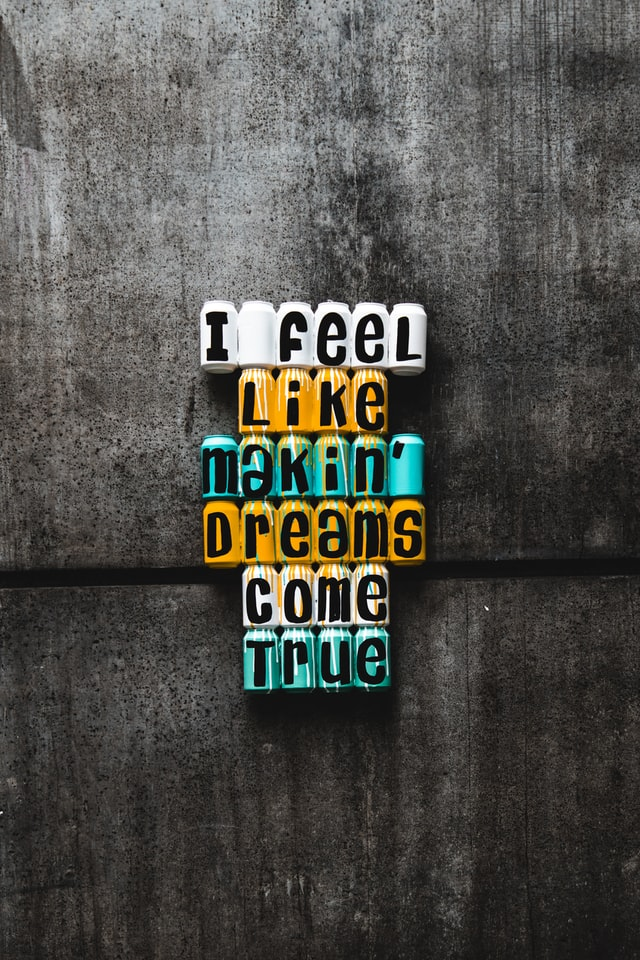

In [12]:
img_file_path = work_dir + '/abc2.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
bs(\

.

| wy

Anke

+o

Cov ig


Done


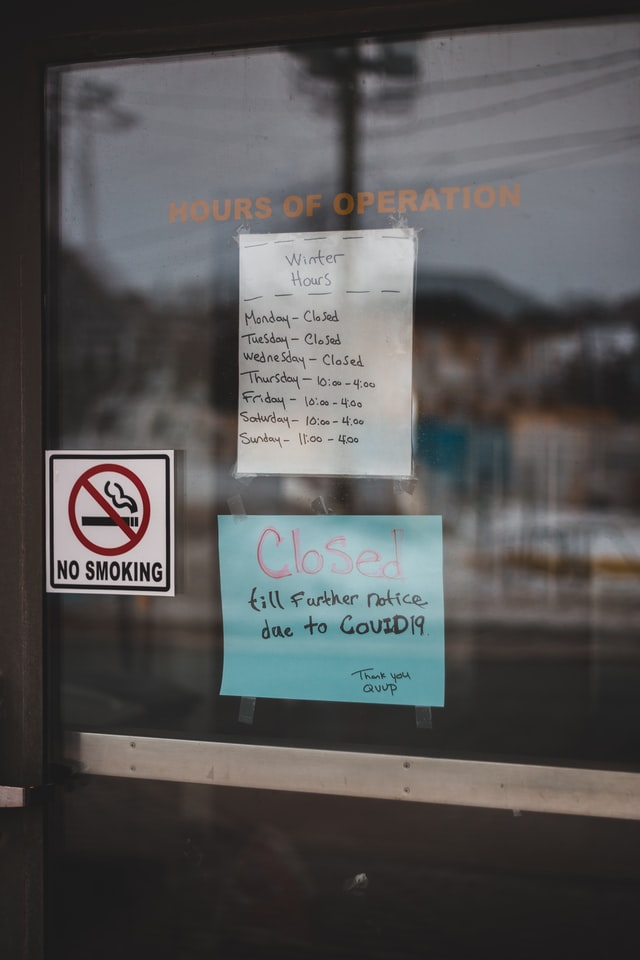

In [13]:
img_file_path = work_dir + '/abc3.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png

Done


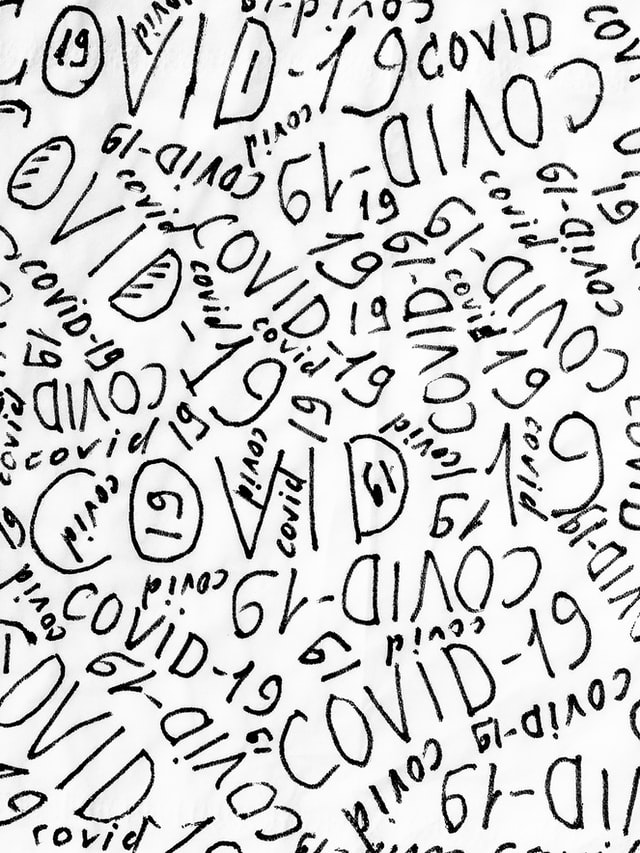

In [14]:
img_file_path = work_dir + '/abc4.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png

Done


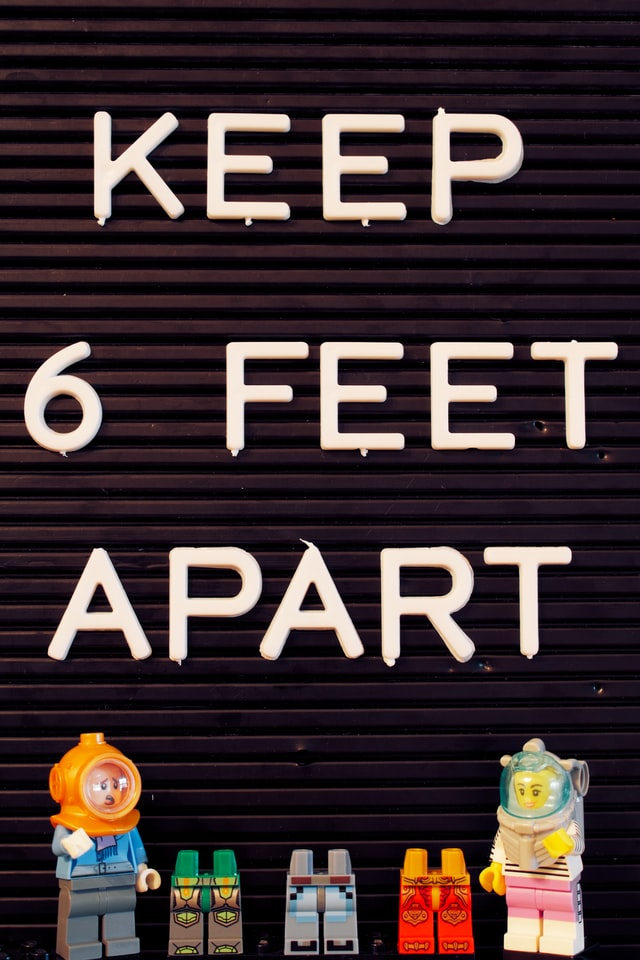

In [15]:
img_file_path = work_dir + '/abc5.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
/home/aiffel-dj47/aiffel/ocr_python/0007.png
SPREAD

POSITIVITY




NOT

THE

VIRUS.

Done


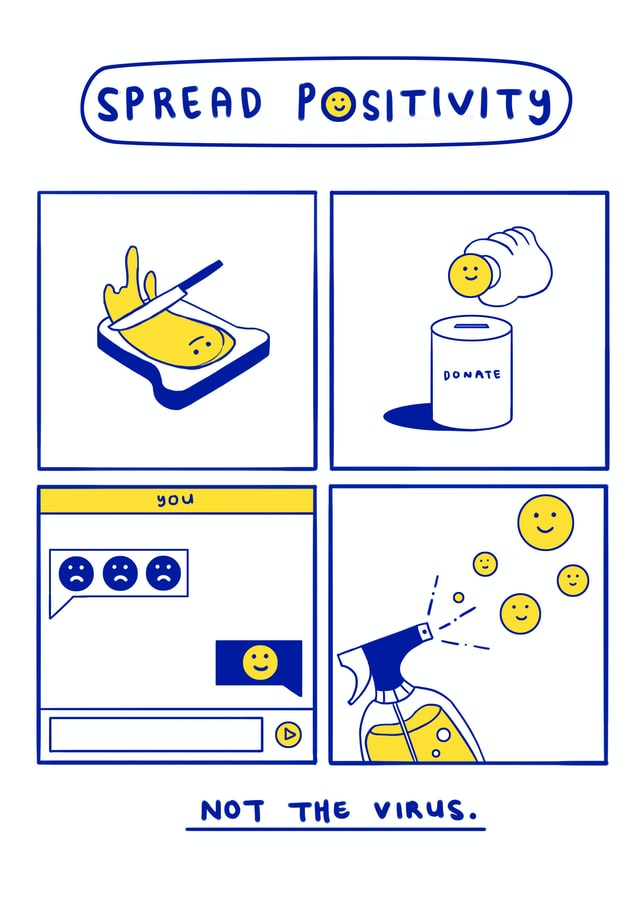

In [16]:
img_file_path = work_dir + '/abc6.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png

Done


In [17]:
img_file_path = work_dir + '/abc7.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
/home/aiffel-dj47/aiffel/ocr_python/0007.png
/home/aiffel-dj47/aiffel/ocr_python/0008.png
/home/aiffel-dj47/aiffel/ocr_python/0009.png
/home/aiffel-dj47/aiffel/ocr_python/0010.png
/home/aiffel-dj47/aiffel/ocr_python/0011.png
/home/aiffel-dj47/aiffel/ocr_python/0012.png
/home/aiffel-dj47/aiffel/ocr_python/0013.png
/home/aiffel-dj47/aiffel/ocr_python/0014.png
/home/aiffel-dj47/aiffel/ocr_python/0015.png
/home/aiffel-dj47/aiffel/ocr_python/0016.png
/home/aiffel-dj47/aiffel/ocr_python/0017.png
/home/aiffel-dj47/aiffel/ocr_python/0018.png
/home/aiffel-dj47/aiffel/ocr_python/0019.png
/home/aiffel-dj47/aiffel/ocr_python/0020.png
/home/aiffel-dj47/aiffel/ocr_python/0021.png
/home/aiff

In [18]:
img_file_path = work_dir + '/abc8.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png

Done


In [19]:
img_file_path = work_dir + '/abc9.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
/home/aiffel-dj47/aiffel/ocr_python/0007.png
/home/aiffel-dj47/aiffel/ocr_python/0008.png
/home/aiffel-dj47/aiffel/ocr_python/0009.png
/home/aiffel-dj47/aiffel/ocr_python/0010.png
/home/aiffel-dj47/aiffel/ocr_python/0011.png
/home/aiffel-dj47/aiffel/ocr_python/0012.png
/home/aiffel-dj47/aiffel/ocr_python/0013.png
/home/aiffel-dj47/aiffel/ocr_python/0014.png
/home/aiffel-dj47/aiffel/ocr_python/0015.png
/home/aiffel-dj47/aiffel/ocr_python/0016.png
/home/aiffel-dj47/aiffel/ocr_python/0017.png
/home/aiffel-dj47/aiffel/ocr_python/0018.png
/home/aiffel-dj47/aiffel/ocr_python/0019.png
/home/aiffel-dj47/aiffel/ocr_python/0020.png
/home/aiffel-dj47/aiffel/ocr_python/0021.png
/home/aiff

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BET IER

DAYS

ARE

COMING

BETTER

DAYS

AKE

COMING

BETTER

DAYS

AKE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BET IER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER


ARE

COMING

BETTER

DAYS

AKE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER


ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER


AKE

COMING

BETTER

DAYS

AKE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER


AKE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER

DAYS

ARE

COMING

BETTER


ARE

COMING

BETTER

DAYS

AKE

COMING

BETTER

DAYS


COMING

BETT

In [23]:
img_file_path = work_dir + '/abc10.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png


SystemError: tile cannot extend outside image

In [24]:
img_file_path = work_dir + '/abc11.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png


SystemError: tile cannot extend outside image

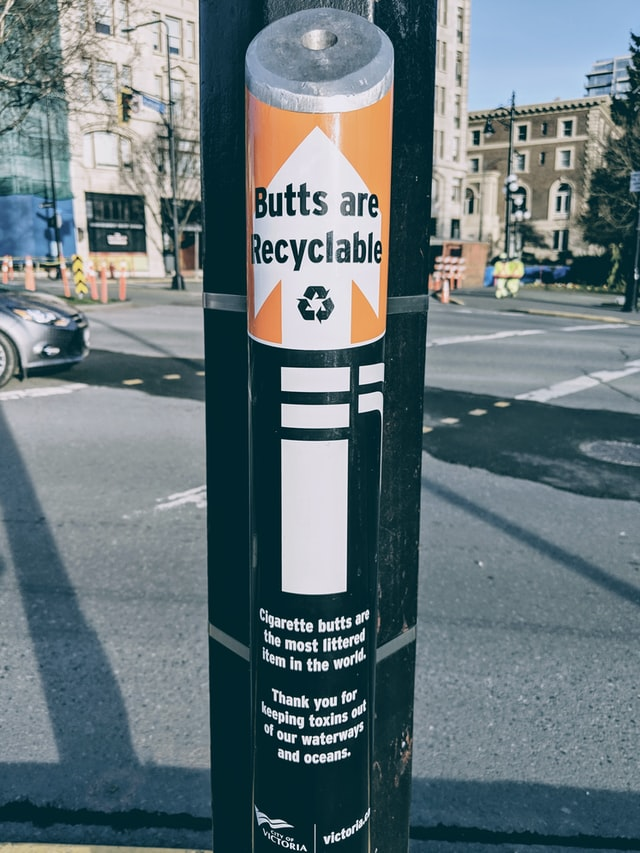

In [25]:
img_file_path = work_dir + '/abc12.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
/home/aiffel-dj47/aiffel/ocr_python/0007.png
/home/aiffel-dj47/aiffel/ocr_python/0008.png
/home/aiffel-dj47/aiffel/ocr_python/0009.png
/home/aiffel-dj47/aiffel/ocr_python/0010.png
/home/aiffel-dj47/aiffel/ocr_python/0011.png
/home/aiffel-dj47/aiffel/ocr_python/0012.png
/home/aiffel-dj47/aiffel/ocr_python/0013.png
/home/aiffel-dj47/aiffel/ocr_python/0014.png
/home/aiffel-dj47/aiffel/ocr_python/0015.png
/home/aiffel-dj47/aiffel/ocr_python/0016.png
/home/aiffel-dj47/aiffel/ocr_python/0017.png
/home/aiffel-dj47/aiffel/ocr_python/0018.png
w/ (TY

AAA AAAKAAAAAKAAAA AAA AA AAA A /









‘\

KX.

WA AX)





AN

DP PPISAIX

Done


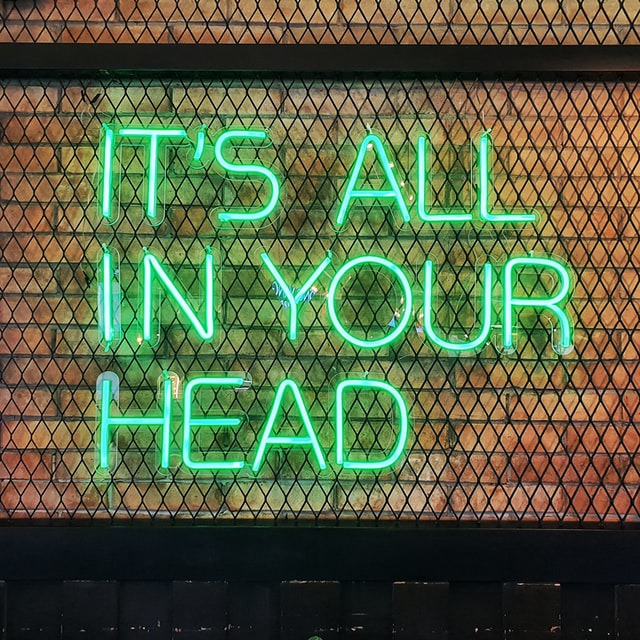

In [26]:
img_file_path = work_dir + '/abc13.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
/home/aiffel-dj47/aiffel/ocr_python/0001.png
/home/aiffel-dj47/aiffel/ocr_python/0002.png
/home/aiffel-dj47/aiffel/ocr_python/0003.png
/home/aiffel-dj47/aiffel/ocr_python/0004.png
/home/aiffel-dj47/aiffel/ocr_python/0005.png
/home/aiffel-dj47/aiffel/ocr_python/0006.png
/home/aiffel-dj47/aiffel/ocr_python/0007.png
/home/aiffel-dj47/aiffel/ocr_python/0008.png
/home/aiffel-dj47/aiffel/ocr_python/0009.png
/home/aiffel-dj47/aiffel/ocr_python/0010.png
oT”

7.


eile

Ei



space

jL@a saiud

e610 primordial

' Mantengea fa distancia

Done


In [27]:
img_file_path = work_dir + '/abc14.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
‘

Done


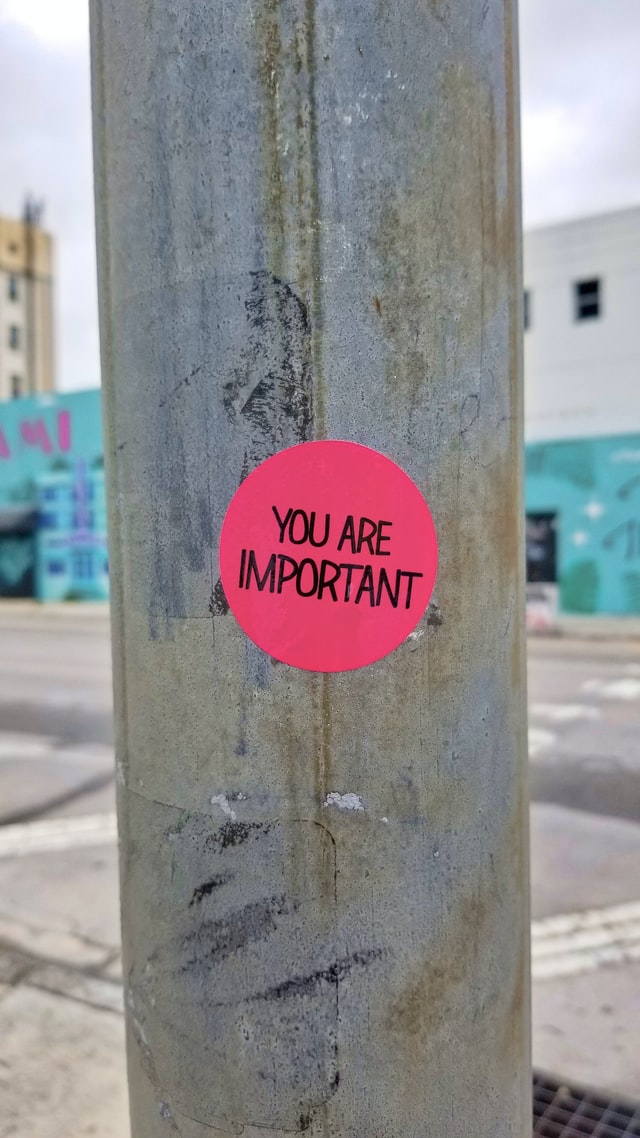

In [28]:
img_file_path = work_dir + '/abc15.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/home/aiffel-dj47/aiffel/ocr_python/0000.png
3

Done


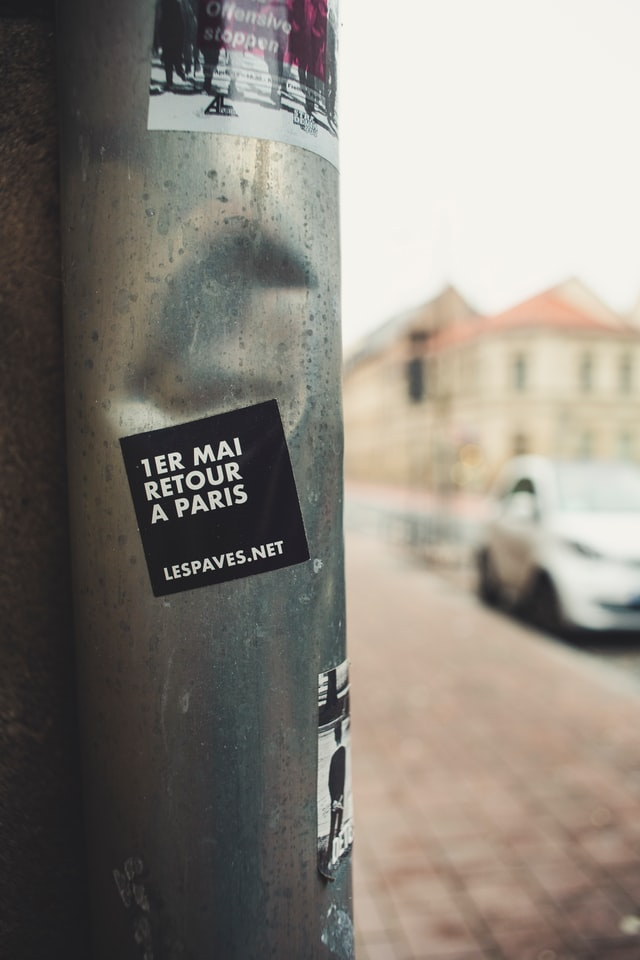

# 총평

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

구현하고자 하는 것은 없었고 그냥 여러 종류의 텍스트(휘어진 텍스트, 네온사인, 손글씨, 일러스트 등등)에 대해 확인해보려고 했다..  
일반 사진이어서 내가 눈으로 직접 확인이 가능하기에 평가기준 또한 그냥 '내 눈에 보인 것에 대한 것을 제대로 출력해주나'였다. 신기한 것은 나는 대충 큰 글자만 봐서 작은 글씨를 놓친 것도 있지만 ocr은 뒤에 숨어져있는 작은 글자도 찾았다.  

이전 노드에서 나온 것 처럼 acc나 loss..? 값을 출력하는 거나 테서렉트가 저장한 히스토리 값을 일일히 출력 해보고싶었지만 아직 어떻게 하는지 모르겠어서 하지 못했다.   

아무튼 실행해본 결과. ocr의 기능이 좋은 것은 아니지만 테서렉트보다 keras-ocr을 사용하는 것이 그나마 결과가 더 좋은 것 같다.  
왜냐하면 테서렉트는 출력 못한 것도 있지만 keras-ocr은 틀리긴 했지만 그래도 출력은 했다는 것이 의미 있는 것 같다.  
google ocr api는 사용해보고 싶었지만 오류가 나서 해볼 수 없었다.